In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For scaling down the data

def scale_data(df):
    """
    Scales the columns of the given DataFrame using MinMaxScaler, excluding the specified columns.

    :param df: pandas DataFrame containing the data to be scaled
    :param exclude_columns: list of columns to exclude from scaling
    :return: scaled DataFrame, scaler object
    """
    exclude_col = ['Date']
    columns_to_scale = [col for col in df.columns if col not in exclude_col]
    
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df_scaled, scaler


def inverse_scale_data(scaled_df, scaler):
    """
    Inversely scales the columns of the given scaled DataFrame using the provided scaler, excluding the specified columns.

    :param scaled_df: pandas DataFrame containing the scaled data
    :param scaler: scaler object used for scaling
    :param exclude_columns: list of columns to exclude from inverse scaling
    :return: original DataFrame
    """
    exclude_col=['Date']
    columns_to_inverse_scale = [col for col in scaled_df.columns if col not in exclude_col]
    df_original = scaled_df.copy()
    df_original[columns_to_inverse_scale] = scaler.inverse_transform(scaled_df[columns_to_inverse_scale])
    
    return df_original

In [3]:
NIFTY = pd.read_csv('D:/UFG/Data collection/NIFTY.csv')
NIFTY['Date']= pd.to_datetime(NIFTY['Date'], format='%Y-%m-%d')

scaled_data, scaler = scale_data(NIFTY)
#original_data = inverse_scale_data(scaled_data, scaler, exclude_col=['Date'])

In [4]:
# IBOV = pd.read_csv('D:/UFG/Data collection/IBOV.csv')
# IBOV['Date']= pd.to_datetime(IBOV['Date'], format='%Y-%m-%d')

# scaled_data, scaler = scale_data(IBOV, exclude_col=['Date'])
#original_data = inverse_scale_data(scaled_data, scaler, exclude_col=['Date'])

In [5]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(14, 7))
# plt.plot(scaled_data['Date'], scaled_data['Close'])

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to transform the original time series to stationary series
def transform_to_stationary(df, period=252):
    df_copy = df.copy()  # Make a copy to avoid modifying the original DataFrame
    df_copy.set_index('Date', inplace=True)

    # For Volume values
    df_copy = df_copy.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    column_names = df_copy.columns
    
    residuals_dict = {}
    trend_dict = {}
    seasonal_dict = {}
    decomposition_results = {}
    
    for column_name in column_names:
        # Perform seasonal decomposition with an additive model
        result = seasonal_decompose(df_copy[column_name], model='additive', period=period)
        
        # Extract components
        residuals = result.resid.dropna()  # Drop NaNs that appear due to the decomposition process
        trend = result.trend.dropna()
        seasonal = result.seasonal.dropna()
        
        # Store components in dictionaries
        residuals_dict[column_name] = residuals
        trend_dict[column_name] = trend
        seasonal_dict[column_name] = seasonal
        decomposition_results[column_name] = result
    
    # Create DataFrames from dictionaries
    df_residuals = pd.DataFrame(residuals_dict)
    df_residuals.index.name = 'Date'
    df_trend = pd.DataFrame(trend_dict)
    df_trend.index.name = 'Date'
    df_seasonal = pd.DataFrame(seasonal_dict)
    df_seasonal.index.name = 'Date'
    
    return df_residuals, df_trend, df_seasonal, decomposition_results

# Function to invert the transformation
def inverse_transform(df_residuals, df_trend, df_seasonal, decomposition_results):
    reconstructed_dict = {}
    
    for column_name in df_residuals.columns:
        # Align indices
        residuals = df_residuals[column_name]
        trend = df_trend[column_name]
        seasonal = df_seasonal[column_name]

        # Reconstruct the original time series
        reconstructed = residuals + trend + seasonal
        reconstructed_dict[column_name] = reconstructed
    
    # Create a DataFrame from reconstructed dictionary
    df_reconstructed = pd.DataFrame(reconstructed_dict)
    df_reconstructed.index.name = 'Date'
    
    return df_reconstructed




In [14]:
# Transform the original time series to stationary series
df_residuals, df_trend, df_seasonal, decomposition_results = transform_to_stationary(scaled_data, period=252)

# Reconstruct the original time series from residuals
df_reconstructed = inverse_transform(df_residuals, df_trend, df_seasonal, decomposition_results)

# Display the first few rows of the original, residuals, trend, seasonal, and reconstructed data

# print("Original Data:")
# print(scaled_data.head())
# print("\nResiduals Data:")
# print(df_residuals.head())
# print("\nTrend Data:")
# print(df_trend.head())
# print("\nSeasonal Data:")
# print(df_seasonal.head())
# print("\nReconstructed Data:")
# print(df_reconstructed.head())

<Axes: xlabel='Date'>

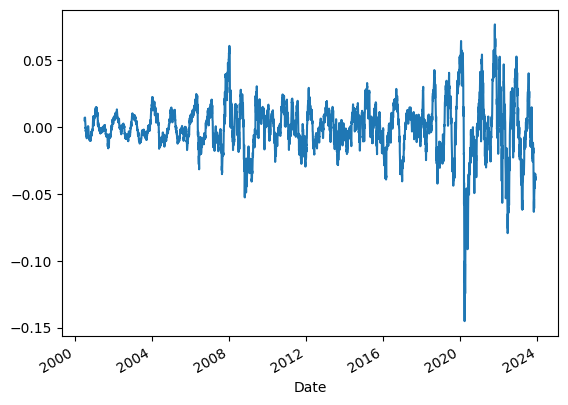

In [15]:
#df_residuals['Close'].plot()

<Axes: xlabel='Date'>

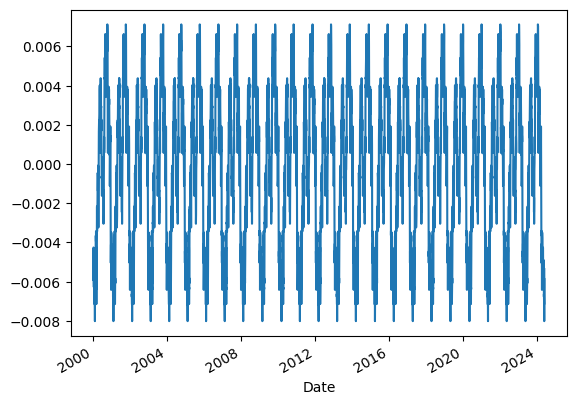

In [16]:
#df_seasonal['Close'].plot()

<Axes: xlabel='Date'>

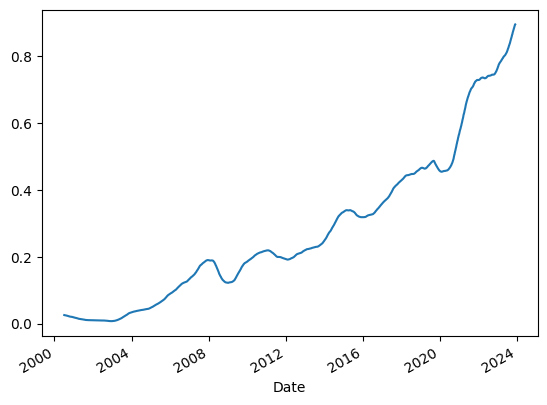

In [17]:
#df_trend['Close'].plot()

In [18]:
# ADF test

def adf_test(df, exclude_columns=[]):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on the specified columns in the DataFrame.

    :param df: pandas DataFrame containing the data
    :param exclude_columns: list of columns to exclude from ADF test
    :return: DataFrame with ADF test results
    """
    adf_results = []

    for col in df.columns:
        result = adfuller(df[col].dropna())
        adf_results.append({
            'Column': col,
            'ADF Statistic': result[0],
            'p-value': format(result[1], ".5f"),
            'Used Lag': result[2],
            'Number of Observations': result[3],
            #'Critical Values': result[4],
            'Stationary': result[1] < 0.05  # If p-value < 0.05, the series is stationary
        })

    return pd.DataFrame(adf_results)


In [19]:
# adf_results = adf_test(df_residuals)
# adf_results

,Column,ADF Statistic,p-value,Used Lag,Number of Observations,Stationary
0,Close,-8.932812,0.00000,34,5784,True
1,Open,-9.464972,0.00000,20,5798,True
2,High,-9.010512,0.00000,34,5784,True
3,Low,-9.027662,0.00000,34,5784,True
4,Volume (in Billion),-12.295776,0.00000,22,5796,True
